In [10]:
from shapely.affinity import rotate
from scipy.ndimage import rotate as scipy_rotate
import matplotlib.pyplot as plt

In [2]:
# get segmentation masks as polygon
from PIL import Image
from ultralytics import YOLO
import numpy as np
from shapely import Polygon
import rasterio.features
import easyocr

input_image = Image.open(r"..\test-data\book_shelf.jpg")
model = YOLO(r"yolov8_n_24aug2023.pt")
reader = easyocr.Reader(['en'])

results = model.predict(source=input_image, save=True, show_labels=False, show_conf=False, boxes=False)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.

0: 480x640 32 book-spines, 168.5ms
Speed: 6.0ms preprocess, 168.5ms inference, 38.9ms postprocess per image at shape (1, 3, 480, 640)
Results saved to e:\Code\shelfscan\runs\segment\predict12


In [79]:
mask_num = 20
bookspine_mask = results[0].masks.xy[mask_num]
mask_polygon = Polygon(bookspine_mask)

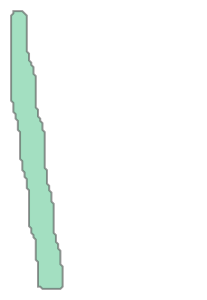

In [80]:
mask_polygon

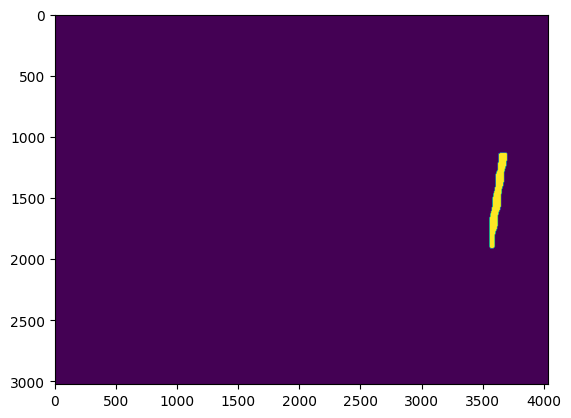

In [81]:
plt.imshow(rasterio.features.rasterize([mask_polygon], out_shape=(input_image.height, input_image.width)))

In [95]:
area = mask_polygon.area
centroid = mask_polygon.centroid.coords[0]

Ix = 0
Iy = 0
Ixy = 0

for i in range(len(mask_polygon.exterior.coords) - 1):
    xi, yi = mask_polygon.exterior.coords[i]
    xi1, yi1 = mask_polygon.exterior.coords[i + 1]

    Ai = xi * yi1 - xi1 * yi
    xi_avg = (xi + xi1) / 2
    yi_avg = (yi + yi1) / 2

    Ix += Ai * (yi_avg - centroid[1]) ** 2
    Iy += Ai * (xi_avg - centroid[0]) ** 2
    Ixy += Ai * (xi_avg - centroid[0]) * (yi_avg - centroid[1])
    
# Calculate the principal axis angle
theta_rad = 0.5 * np.arctan2(2 * Ixy, Ix - Iy)
theta_deg = np.degrees(theta_rad)

print("Principal Axis Angle:", theta_deg)
# need to normalize between negative and positive principal axis angles

Principal Axis Angle: 84.45540279220839


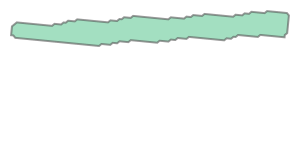

In [111]:
rotate_to_flat = -theta_deg
rotated_mask_polygon = rotate(mask_polygon, -rotate_to_flat)
rotated_mask_polygon

In [112]:
def get_polygon_bounds_for_slicing(mask_polygon):
    bounds_int = [int(_) for _ in mask_polygon.bounds] # .bounds returns floats, convert to int for slicing
    min_x, min_y, max_x, max_y = bounds_int
    return  min_x, min_y, max_x, max_y

In [113]:
mask_bitmap = rasterio.features.rasterize([mask_polygon], out_shape=(input_image.height, input_image.width))
input_image_bw = input_image.convert("L")
input_image_masked = input_image_bw * mask_bitmap
min_x, min_y, max_x, max_y = get_polygon_bounds_for_slicing(mask_polygon)
input_image_masked_bounded = input_image_masked[min_y:max_y,min_x:max_x]

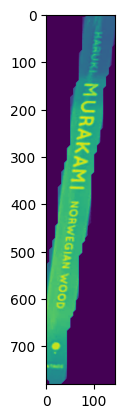

In [114]:
plt.imshow(input_image_masked_bounded)

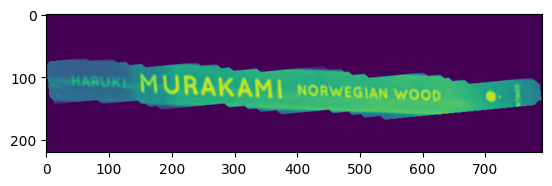

In [115]:
rotated_array_arbitrary = scipy_rotate(input_image_masked_bounded, rotate_to_flat+180, reshape=True)
plt.imshow(rotated_array_arbitrary)

In [116]:
def get_bookspine_text_from_ocr(ocr_results):
    return ' '.join([_[1] for _ in ocr_results])

In [117]:
bookspine_ocr = reader.readtext(input_image_masked_bounded)
bookspine_text = get_bookspine_text_from_ocr(bookspine_ocr)
print(f'original mask returns {bookspine_text}')

original mask returns 1 1 1 8


In [118]:
rotated_array_1 = scipy_rotate(input_image_masked_bounded, rotate_to_flat, reshape=True)
bookspine_ocr = reader.readtext(rotated_array_1)
bookspine_text = get_bookspine_text_from_ocr(bookspine_ocr)
print(f'rotatation 1 mask returns {bookspine_text}')

rotatation 1 mask returns doom Nvid]Mhon Uwiavunw mXnevh


In [119]:
rotated_array_2 = scipy_rotate(input_image_masked_bounded, rotate_to_flat+90, reshape=True)
bookspine_ocr = reader.readtext(rotated_array_2)
bookspine_text = get_bookspine_text_from_ocr(bookspine_ocr)
print(f'rotatation 2 mask returns {bookspine_text}')

rotatation 2 mask returns 1 1 1 8


In [120]:
rotated_array_3 = scipy_rotate(input_image_masked_bounded, rotate_to_flat+180, reshape=True)
bookspine_ocr = reader.readtext(rotated_array_3)
bookspine_text = get_bookspine_text_from_ocr(bookspine_ocr)
print(f'rotatation 3 mask returns {bookspine_text}')

rotatation 3 mask returns Haruki MURAKAMI Norwegian Wood


In [121]:
rotated_array_4 = scipy_rotate(input_image_masked_bounded, rotate_to_flat+270, reshape=True)
bookspine_ocr = reader.readtext(rotated_array_4)
bookspine_text = get_bookspine_text_from_ocr(bookspine_ocr)
print(f'rotatation 4 mask returns {bookspine_text}')

rotatation 4 mask returns 8 1 1 1
